# Human Image Segmentation using U-Net (PyTorch)

## Overview
This project focuses on **human image segmentation** using a deep learning model based on **U-Net architecture** implemented in **PyTorch**.

The goal is to accurately segment human silhouettes from input images using a supervised learning approach.

## Key Features
- U-Net based segmentation model
- PyTorch implementation
- Albumentations for image-mask augmentation
- Binary segmentation with Dice Loss
- GPU training support

## Dataset
Human Segmentation Dataset  
Original dataset author: https://github.com/ali-mohamadpour/human-segmentation-unet/data

## Output
The model predicts a binary mask highlighting the human region in the image.



# Task 1 : Set up colab gpu runtime environment

In [1]:
!pip install segmentation-models-pytorch
!pip install -U git+https://github.com/albumentations-team/albumentations
!pip install --upgrade opencv-contrib-python

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.8/154.8 kB 9.6 MB/s eta 0:00:00
  Cloning https://github.com/albumentations-team/albumentations to /tmp/pip-req-build-ufw06vt7
  Running command git clone --filter=blob:none --quiet https://github.com/albumentations-team/albumentations /tmp/pip-req-build-ufw06vt7
  Resolved https://github.com/albumentations-team/albumentations to commit 66212d77a44927a29d6a0e81621d3c27afbd929c
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Attempting uninstall: albucore
    Found existing installation: albucore 0.0.24
    Uninstalling albucore-0.0.24:
      Successfully uninstalled albucore-0.0.24
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
albumentations 2.0.8 requires albucore==0.0.24, but you have albucore 0.0.28 which is incompatible.

# Download Dataset

original author of the dataset :
https://github.com/ali-mohamadpour/human-segmentation-unet/data


In [2]:
!git clone https://github.com/ali-mohamadpour/human-segmentation-unet.git


Cloning into 'human-segmentation-unet'...
remote: Enumerating objects: 655, done.
remote: Counting objects: 100% (655/655), done.
remote: Compressing objects: 100% (652/652), done.
remote: Total 655 (delta 27), reused 0 (delta 0), pack-reused 0 (from 0)
Receiving objects: 100% (655/655), 28.37 MiB | 17.56 MiB/s, done.
Resolving deltas: 100% (27/27), done.


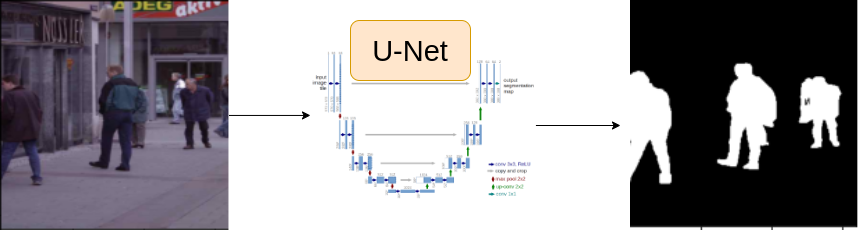

# Some Common Imports

In [32]:
import sys
sys.path.append('/content/human-segmentation-unet')

In [34]:
import torch
import cv2

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from tqdm import tqdm

import helper

# Task : 2 Setup Configurations

In [35]:
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"


In [36]:
CONFIG = {
    "IMAGE_SIZE": 256,
    "BATCH_SIZE": 8,
    "EPOCHS": 25,
    "LR": 1e-4
}


In [37]:
torch.manual_seed(42)
np.random.seed(42)

image = cv2.cvtColor(
    cv2.imread('/content/human-segmentation-unet/data/Training_Images/100.jpg'),
    cv2.COLOR_BGR2RGB
)

mask = cv2.imread(
    '/content/human-segmentation-unet/data/Ground_Truth/100.png',
    0
)



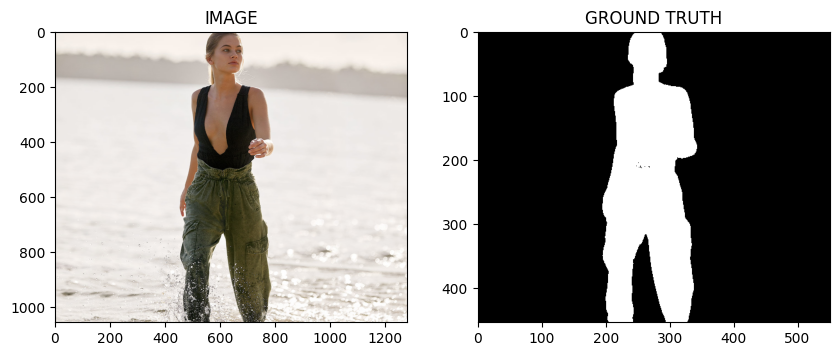

In [38]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,5))

ax1.set_title('IMAGE')
ax1.imshow(image)

ax2.set_title('GROUND TRUTH')
ax2.imshow(mask,cmap = 'gray')

In [39]:
plt.show()




# Task 3 : Augmentation Functions

albumentation documentation : https://albumentations.ai/docs/

In [40]:
import albumentations as A
from albumentations.pytorch import ToTensorV2

train_transform = A.Compose([
    A.Resize(height=CONFIG["IMAGE_SIZE"], width=CONFIG["IMAGE_SIZE"]),
    A.HorizontalFlip(p=0.5),
    A.RandomBrightnessContrast(p=0.2),
    A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
    ToTensorV2()
])

In [41]:
val_transform = A.Compose([
    A.Resize(height=CONFIG["IMAGE_SIZE"], width=CONFIG["IMAGE_SIZE"]),
    A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
    ToTensorV2()
])

# Task 4 : Create Custom Dataset

In [43]:
from torch.utils.data import Dataset, DataLoader
import os
from PIL import Image

class HumanSegDataset(Dataset):
    def __init__(self, image_paths, mask_paths, transform=None):
        self.image_paths = image_paths
        self.mask_paths = mask_paths
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image = np.array(Image.open(self.image_paths[idx]).convert("RGB"))
        mask = np.array(Image.open(self.mask_paths[idx]).convert("L"))
        mask = cv2.resize(mask, (image.shape[1], image.shape[0]), interpolation=cv2.INTER_NEAREST)

        if self.transform:
            augmented = self.transform(image=image, mask=mask)
            image = augmented['image']
            mask = augmented['mask']

        return image, mask



In [44]:
image_dir = '/content/human-segmentation-unet/data/Training_Images'
mask_dir = '/content/human-segmentation-unet/data/Ground_Truth'

all_images = sorted([os.path.join(image_dir, f) for f in os.listdir(image_dir) if f.endswith('.jpg')])
all_masks = sorted([os.path.join(mask_dir, f) for f in os.listdir(mask_dir) if f.endswith('.png')])

train_imgs, val_imgs, train_masks, val_masks = train_test_split(all_images, all_masks, test_size=0.2, random_state=42)


In [45]:
trainset = HumanSegDataset(train_imgs, train_masks, transform=train_transform)
validset = HumanSegDataset(val_imgs, val_masks, transform=val_transform)

train_loader = DataLoader(trainset, batch_size=CONFIG["BATCH_SIZE"], shuffle=True)
valid_loader = DataLoader(validset, batch_size=CONFIG["BATCH_SIZE"], shuffle=False)


In [46]:
print(f"Size of Trainset : {len(trainset)}")
print(f"Size of Validset : {len(validset)}")

Size of Trainset : 232
Size of Validset : 58


In [47]:
sample_img, sample_mask = next(iter(train_loader))
print(f"Sample image shape: {sample_img.shape}")
print(f"Sample mask shape: {sample_mask.shape}")


Sample image shape: torch.Size([8, 3, 256, 256])
Sample mask shape: torch.Size([8, 256, 256])


# Task 5 : Load dataset into batches

In [48]:
from torch.utils.data import DataLoader


In [49]:
train_loader = DataLoader(
    trainset,
    batch_size=CONFIG["BATCH_SIZE"],
    shuffle=True,
    num_workers=2
)


In [50]:
valid_loader = DataLoader(
    validset,
    batch_size=CONFIG["BATCH_SIZE"],
    shuffle=False,
    num_workers=2
)


In [51]:
sample_imgs, sample_masks = next(iter(train_loader))
print(f"Train batch images shape: {sample_imgs.shape}")
print(f"Train batch masks shape: {sample_masks.shape}")


Train batch images shape: torch.Size([8, 3, 256, 256])
Train batch masks shape: torch.Size([8, 256, 256])


# Task 6 : Create Segmentation Model

segmentation_models_pytorch documentation : https://smp.readthedocs.io/en/latest/

In [52]:
import segmentation_models_pytorch as smp


In [53]:
model = smp.Unet(
    encoder_name="resnet34",
    encoder_weights="imagenet",
    in_channels=3,
    classes=1
).to(DEVICE)


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/156 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/87.3M [00:00<?, ?B/s]

In [54]:
import torch.optim as optim
import torch.nn as nn

criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=CONFIG["LR"])


# Task 7 : Create Train and Validation Function

In [55]:
def train_fn(loader, model, optimizer, criterion, device):
    model.train()
    running_loss = 0.0

    for images, masks in loader:
        images = images.to(device)
        masks = masks.to(device).unsqueeze(1).float()  # [B, 1, H, W]

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, masks)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * images.size(0)

    epoch_loss = running_loss / len(loader.dataset)
    return epoch_loss


In [56]:
def valid_fn(loader, model, criterion, device):
    model.eval()
    running_loss = 0.0

    with torch.no_grad():
        for images, masks in loader:
            images = images.to(device)
            masks = masks.to(device).unsqueeze(1).float()

            outputs = model(images)
            loss = criterion(outputs, masks)

            running_loss += loss.item() * images.size(0)

    epoch_loss = running_loss / len(loader.dataset)
    return epoch_loss


# Task 8 : Train Model



In [57]:
num_epochs = CONFIG["EPOCHS"]

for epoch in range(num_epochs):
    train_loss = train_fn(train_loader, model, optimizer, criterion, DEVICE)
    valid_loss = valid_fn(valid_loader, model, criterion, DEVICE)

    print(f"Epoch [{epoch+1}/{num_epochs}] | Train Loss: {train_loss:.4f} | Valid Loss: {valid_loss:.4f}")


Epoch [1/25] | Train Loss: -120.5166 | Valid Loss: -355.8268
Epoch [2/25] | Train Loss: -247.2181 | Valid Loss: -327.7844
Epoch [3/25] | Train Loss: -323.2081 | Valid Loss: -381.0175
Epoch [4/25] | Train Loss: -380.1862 | Valid Loss: -411.5598
Epoch [5/25] | Train Loss: -437.5620 | Valid Loss: -473.4502
Epoch [6/25] | Train Loss: -487.4227 | Valid Loss: -455.7972
Epoch [7/25] | Train Loss: -531.2195 | Valid Loss: -513.9101
Epoch [8/25] | Train Loss: -579.0702 | Valid Loss: -525.9737
Epoch [9/25] | Train Loss: -623.5929 | Valid Loss: -569.6859
Epoch [10/25] | Train Loss: -674.5714 | Valid Loss: -608.7641
Epoch [11/25] | Train Loss: -718.1846 | Valid Loss: -712.8357
Epoch [12/25] | Train Loss: -770.9236 | Valid Loss: -722.3812
Epoch [13/25] | Train Loss: -817.1885 | Valid Loss: -768.9496
Epoch [14/25] | Train Loss: -860.4163 | Valid Loss: -773.6922
Epoch [15/25] | Train Loss: -904.8463 | Valid Loss: -821.0599
Epoch [16/25] | Train Loss: -952.7804 | Valid Loss: -903.0312
Epoch [17/25] | T

In [58]:
  num_epochs = CONFIG["EPOCHS"]
best_loss = float('inf')

for epoch in range(num_epochs):
    train_loss = train_fn(train_loader, model, optimizer, criterion, DEVICE)
    valid_loss = valid_fn(valid_loader, model, criterion, DEVICE)

    print(f"Epoch [{epoch+1}/{num_epochs}] | Train Loss: {train_loss:.4f} | Valid Loss: {valid_loss:.4f}")


    if valid_loss < best_loss:
        best_loss = valid_loss
        torch.save(model.state_dict(), "best_model.pth")
        print("Saved Best Model")



Epoch [1/25] | Train Loss: -1473.4751 | Valid Loss: -1340.5215
Saved Best Model
Epoch [2/25] | Train Loss: -1522.7890 | Valid Loss: -1413.9498
Saved Best Model
Epoch [3/25] | Train Loss: -1574.5728 | Valid Loss: -1498.9658
Saved Best Model
Epoch [4/25] | Train Loss: -1631.8641 | Valid Loss: -1524.1020
Saved Best Model
Epoch [5/25] | Train Loss: -1689.1503 | Valid Loss: -1561.3576
Saved Best Model
Epoch [6/25] | Train Loss: -1733.0831 | Valid Loss: -1634.3190
Saved Best Model
Epoch [7/25] | Train Loss: -1793.7642 | Valid Loss: -1718.7225
Saved Best Model
Epoch [8/25] | Train Loss: -1841.9121 | Valid Loss: -1716.4105
Epoch [9/25] | Train Loss: -1908.2588 | Valid Loss: -1690.1910
Epoch [10/25] | Train Loss: -1928.0543 | Valid Loss: -1735.1915
Saved Best Model
Epoch [11/25] | Train Loss: -2014.4937 | Valid Loss: -1761.0645
Saved Best Model
Epoch [12/25] | Train Loss: -2066.5945 | Valid Loss: -1949.3005
Saved Best Model
Epoch [13/25] | Train Loss: -2142.2929 | Valid Loss: -1857.6416
Epoch [

# Task 9 : Inference

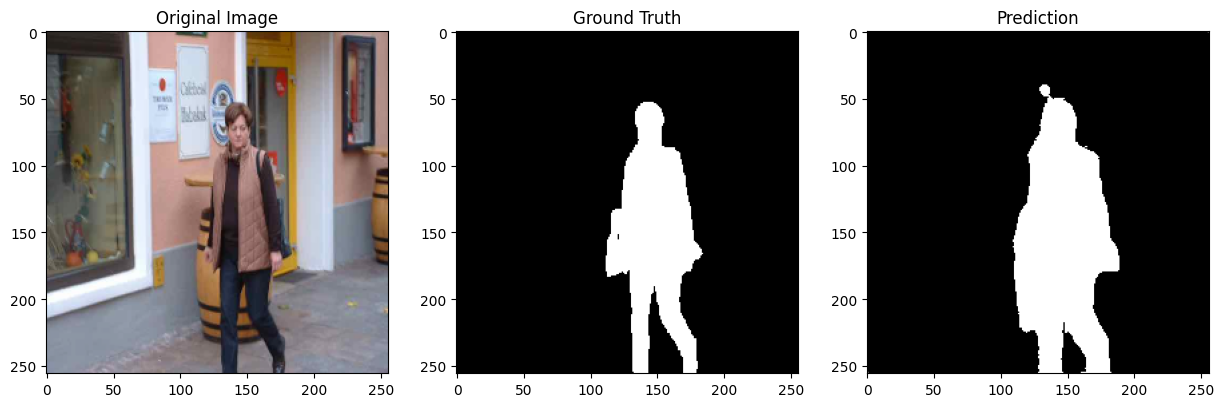

In [67]:
import torch
import matplotlib.pyplot as plt

model.load_state_dict(torch.load("best_model.pth", map_location=DEVICE))
model.eval()

images, masks = next(iter(valid_loader))
images = images.to(DEVICE)

with torch.no_grad():
    outputs = model(images)
    preds = torch.sigmoid(outputs)
    preds = (preds > 0.5).float()


image = images[0].cpu().permute(1, 2, 0).numpy()
mean = np.array([0.485, 0.456, 0.406])
std = np.array([0.229, 0.224, 0.225])
image = image * std + mean
image = np.clip(image, 0, 1)

mask = masks[0].cpu().numpy()
pred = preds[0].cpu().squeeze().numpy()

f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15,5))
ax1.set_title("Original Image")
ax1.imshow(image)
ax2.set_title("Ground Truth")
ax2.imshow(mask, cmap="gray")
ax3.set_title("Prediction")
ax3.imshow(pred, cmap="gray")
plt.show()



##  Acknowledgements

Thank you for taking the time to explore this project, run the code, and review the implementation.  
Your feedback, suggestions, and contributions are greatly appreciated and can help improve this project.
 follow me on...

Linkedin : www.linkedin.com/in/ali-mohammadpour